## **Patch Camelyon Project CNN + Attention training**

### **Import required resources**


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print(f"Running on TPU: {tpu.cluster_spec().as_dict()}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Running on GPU: {gpus[0].name}")
    else:
        cpus = tf.config.list_physical_devices('CPU')
        print(f"Running on CPU: {cpus[0].name}")

Running on TPU: {}


### **Load Dataset**

In [ ]:
# Load the PatchCamelyon dataset
train_dataset, val_dataset, test_dataset = tfds.load(
    'patch_camelyon',
    split=['train[:85%]', 'train[85%:]', 'test'],
    as_supervised=True
)

In [ ]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 222822
Number of validation examples: 39322
Number of test examples: 32768


### **Data Preparation**

#### a) Preprocessing and Data Augmentation

In [ ]:
def preprocess(image, label, augment=False):
    image = tf.image.convert_image_dtype(image, tf.float32)

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label

In [ ]:
train_dataset = (train_dataset
                 .map(lambda x, y: preprocess(x, y, augment=True))
                 .shuffle(1000)
                 .batch(128)
                 .cache()
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
val_dataset = (val_dataset
               .map(preprocess)
               .batch(128)
               .cache()
               .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
test_dataset = (test_dataset
                .map(preprocess)
                .batch(128)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))

Train Dataset Images:


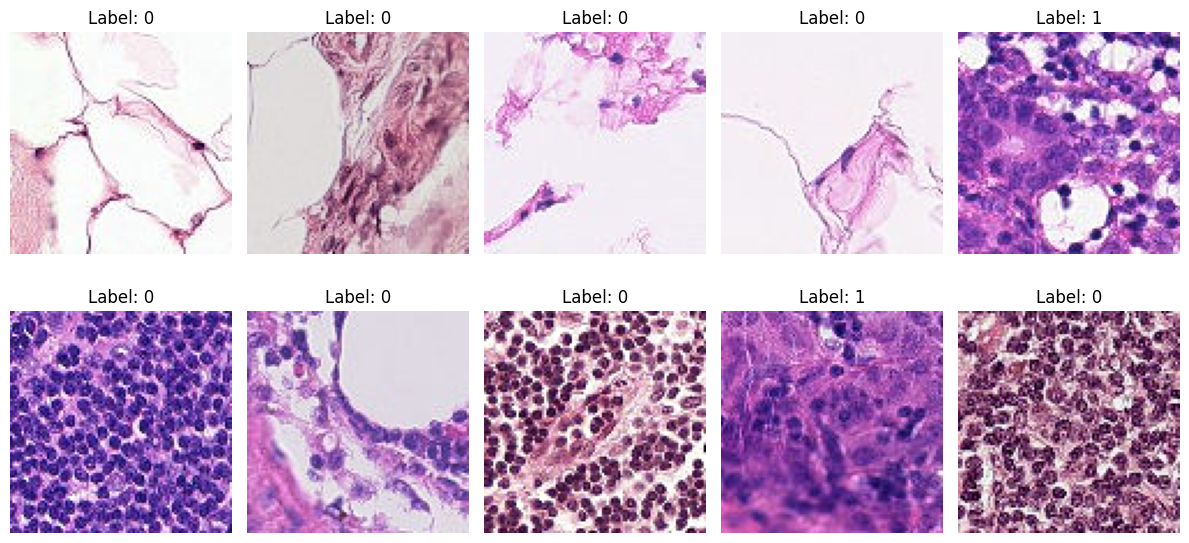

Test Dataset Images:


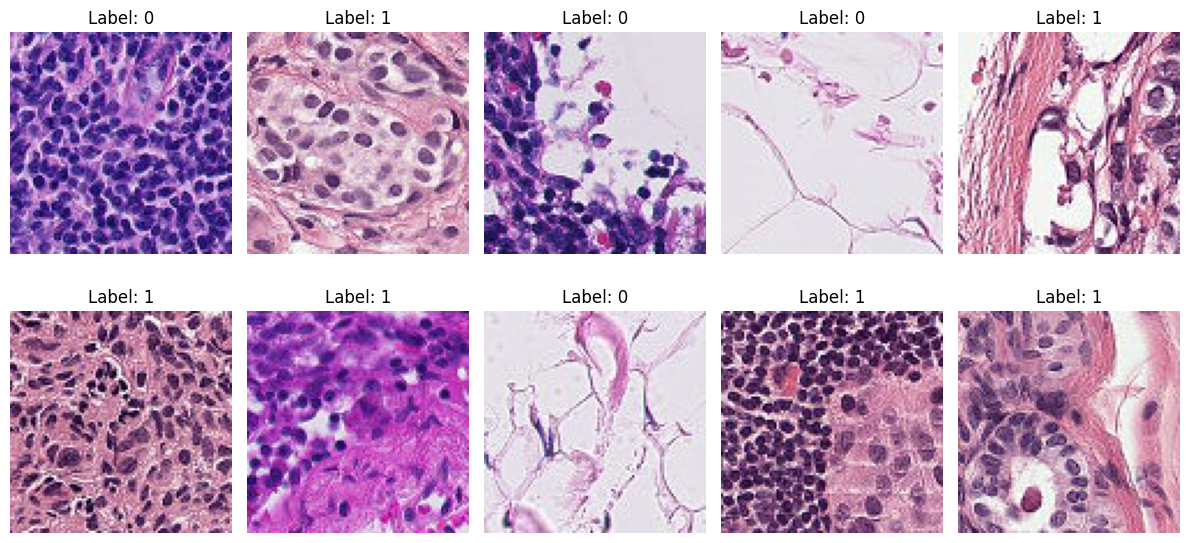

In [ ]:
import matplotlib.pyplot as plt

def plot_images(dataset, num_images=10):
    plt.figure(figsize=(12, 6))
    images_plotted = 0

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if images_plotted < num_images:
                plt.subplot(2, 5, images_plotted + 1)
                plt.imshow(images[i].numpy())
                plt.title(f"Label: {labels[i].numpy():.0f}")
                plt.axis('off')
                images_plotted += 1
            else:
                break
        if images_plotted >= num_images:
            break

    plt.tight_layout()
    plt.show()

print("Train Dataset Images:")
plot_images(train_dataset)

print("Test Dataset Images:")
plot_images(test_dataset)

### **Model Fitting**

#### *CNN + Attention Layer Model Architecture*

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

class AttentionBlock(layers.Layer):
    def __init__(self, units, l2_factor=1e-4):
        super(AttentionBlock, self).__init__()
        self.units = units
        self.query_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))
        self.key_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))
        self.value_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))
        self.attention_output_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        attention_output = tf.matmul(attention_weights, value)
        attention_output = self.attention_output_dense(attention_output)
        return attention_output

def build_attention_model(input_shape=(96, 96, 3), l2_factor=1e-4):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_factor))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_factor))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_factor))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Reshape((-1, x.shape[-1]))(x)
    attention_output = AttentionBlock(units=128, l2_factor=l2_factor)(x)
    attention_output = layers.GlobalAveragePooling1D()(attention_output)

    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_factor))(attention_output)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_factor))(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


#### Fitting the model with EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

attention_model = build_attention_model()

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

attention_model.summary()

history = attention_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping]
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 256)       2951

### **Model Evaluation**

#### a) Evaluation Metrics:
1. Accuracy
2. F1 Score
3. Precision
4. Recall
5. Confusion Matrix

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = attention_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

256/256 [==============================] - 41s 158ms/step
Accuracy: 0.831
F1 Score: 0.808
Precision: 0.938
Recall: 0.709


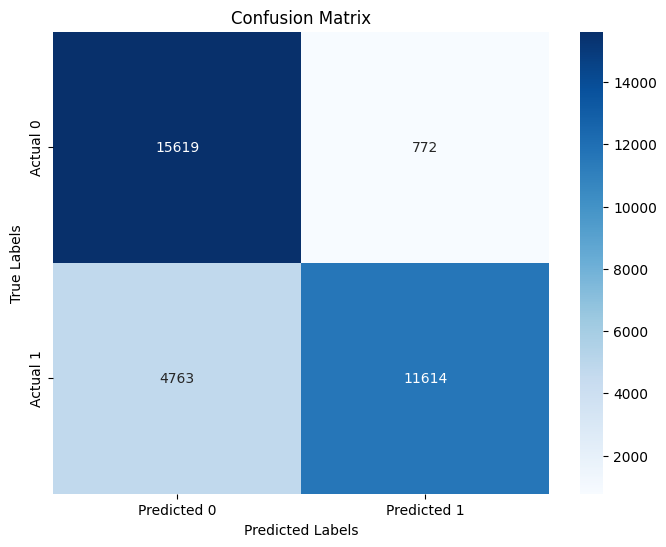

In [ ]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### b) Learning Curves

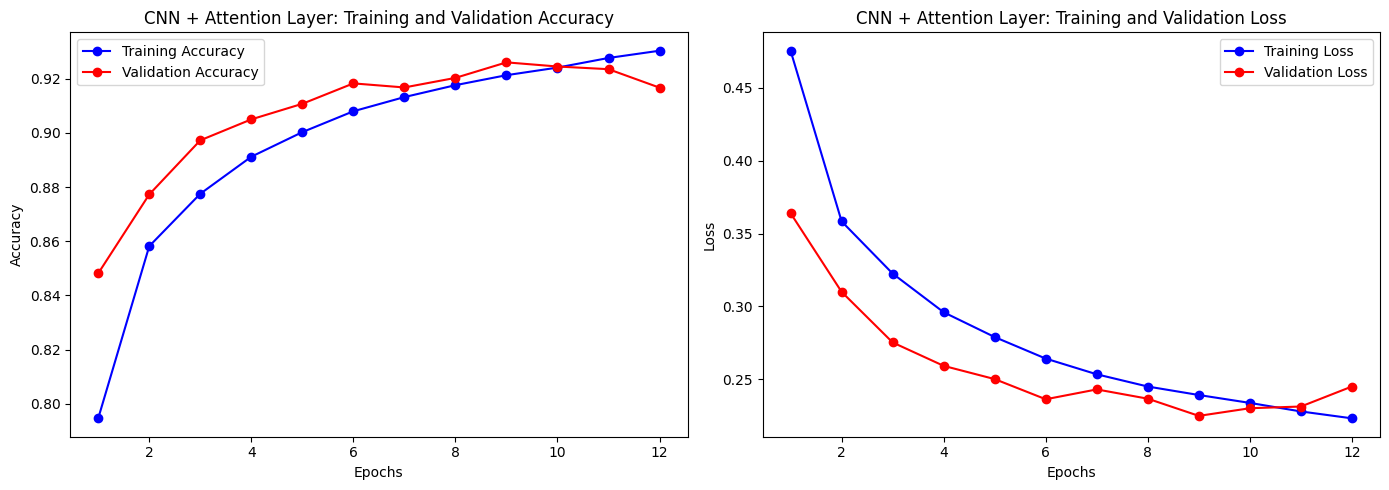

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('CNN + Attention Layer: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('CNN + Attention Layer: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### c) Gradient-weighted Class Activation Mapping

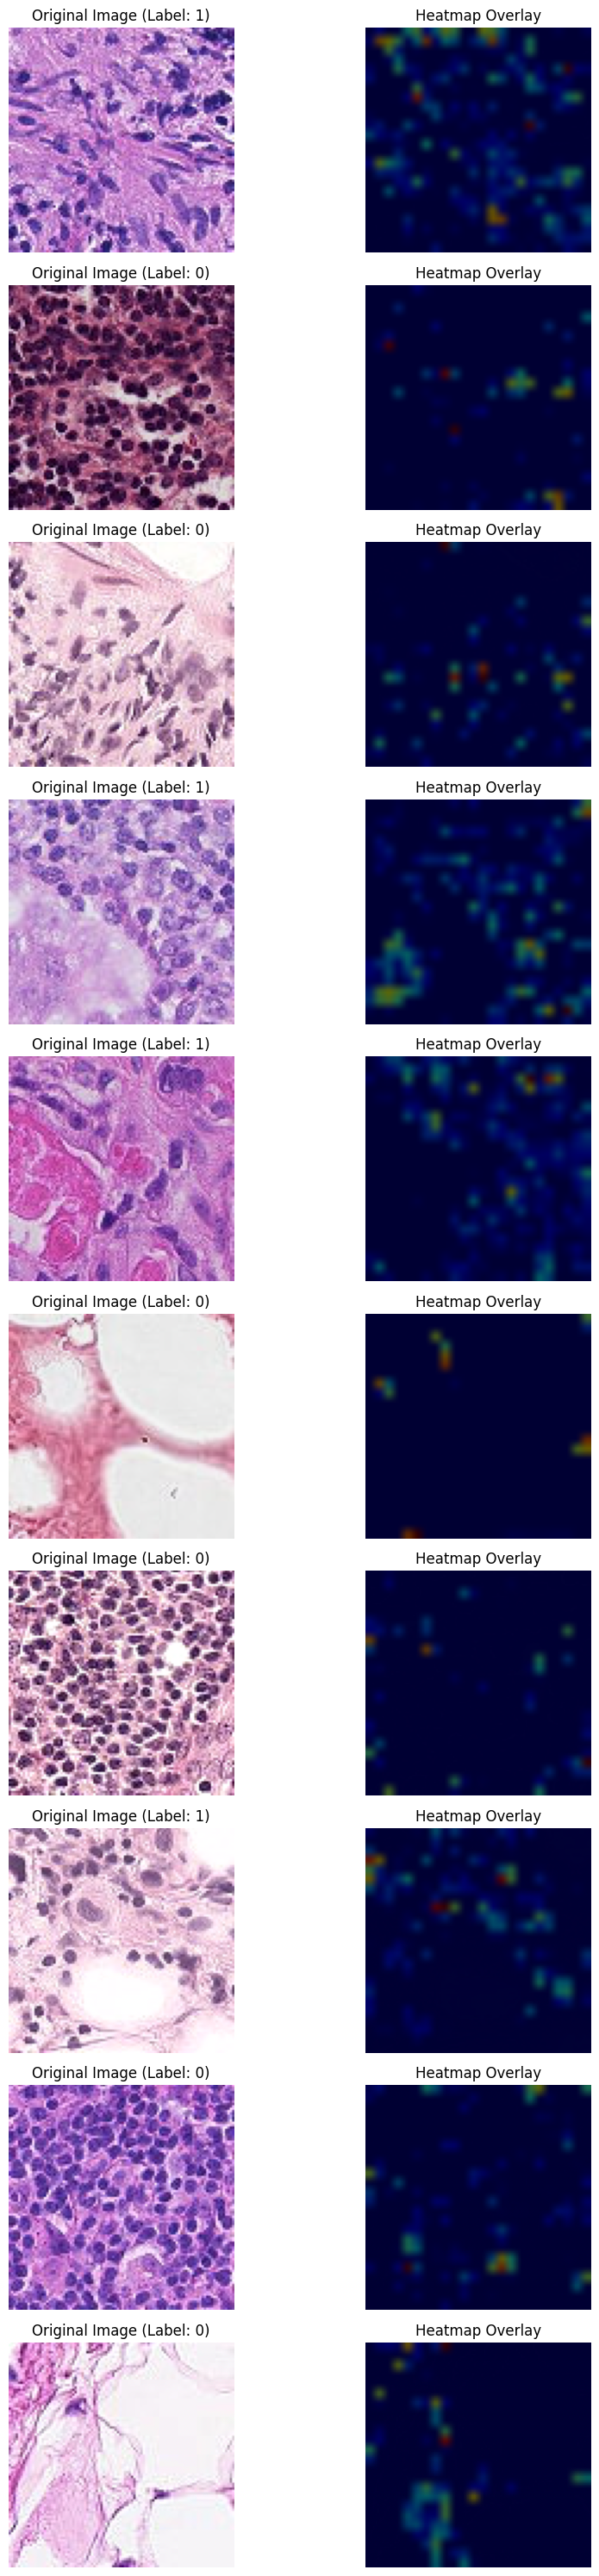

In [ ]:
def generate_gradcam(model, image, layer_name, class_index=None):

    image = tf.expand_dims(image, axis=0)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        feature_maps, predictions = grad_model(image)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_output = predictions[:, class_index]

    gradients = tape.gradient(class_output, feature_maps)
    pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))

    feature_maps = feature_maps[0]
    heatmap = tf.reduce_sum(pooled_gradients * feature_maps, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

def overlay_heatmap(image, heatmap, alpha=0.4):

    heatmap = np.uint8(255 * heatmap)
    heatmap = plt.cm.jet(heatmap)[:, :, :3]
    heatmap = tf.image.resize(heatmap, (image.shape[0], image.shape[1])).numpy()

    overlay = alpha * heatmap + image / 255.0
    return np.clip(overlay, 0, 1)

def visualize_train_images(model, train_dataset, layer_name, num_images=10):

    for images, labels in train_dataset.take(2):
        images = images[:num_images]
        labels = labels[:num_images]

    plt.figure(figsize=(10, 3 * num_images))
    for i in range(num_images):
        heatmap = generate_gradcam(model, images[i], layer_name)

        overlay = overlay_heatmap(images[i].numpy(), heatmap)

        plt.subplot(num_images, 2, 2 * i + 1)
        plt.title(f"Original Image (Label: {labels[i].numpy()})")
        plt.imshow(images[i])
        plt.axis("off")

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.title("Heatmap Overlay")
        plt.imshow(overlay)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

layer_name = "conv2d_5"
visualize_train_images(attention_model, train_dataset, layer_name, num_images=10)

In [ ]:
model_save_path = '/content/drive/My Drive/model_attention_improved.h5'

attention_model.save(model_save_path)